# Layer 2 
- Preprocesamiento de PDFs en Proyecto de OCR

## Objetivo

- Optimizar la calidad y consistencia de un conjunto de documentos PDF, con el objetivo de preparar los datos para el entrenamiento de un modelo de Reconocimiento Óptico de Caracteres (OCR).

---

## Metodologia


## 1. Toma de muestra de archivos PDF

- **Propósito**: Estudiar una muestra de los archivos PDF para determinar la mejor manera de segmentarlos.

- **Metodología**: Se separa una muestra aleatoria de 100 archivos para analizar sus metadatos. Se utiliza la librería `pandas` para cargar el CSV generado en el paso anterior y realizar un análisis exploratorio de los datos.

## 2. Analisis de los Metadatos de los PDFs

- **Propósito**: Establecer un procedimiento que nos permita segmentar estos archivos de manera efectiva.

- **Metodología**: Se utiliza un script Python para procesar todos los archivos PDF en un directorio específico y extraer sus metadatos. La función `process_directory()` recorre cada archivo PDF, extrae sus metadatos y los guarda en un archivo CSV.

## 3. Análisis de Archivos Convertidos de Imágenes a PDFs

- **Propósito**: Establecer un procedimiento que nos permita segmentar estos archivos de manera efectiva.
- **Metodología**: A partir de la identificacion de un conjunto específico de archivos que presentan características distintas al resto del dataset. Se realiza un análisis de los archivos para determinar la mejor manera de segmentarlos.



## 4. Análisis de Calidad de Archivos basado en la fuente de creación del Dato

- **Propósito**: Analizar la proporción de archivos en cada categoría. Una vez realizado este análisis, evaluaremos si es necesario aplicar técnicas de balanceo de datos.
- **Metodología**: Generaremos un CSV que contenga la totalidad de archivos, a partir del cual analizaremos la proporción y distribución de estos datos.

---



# 1 -Toma de muestra de archivos PDF

In [22]:
import os
import random
import shutil

def sample_files(directory_path, sample_size=100, destination_folder="metadata_sample"):
    """
    Toma una muestra aleatoria de archivos de un directorio y los copia a una carpeta de destino.
    """
    # Obtener una lista de todos los archivos en el directorio
    all_files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
    
    # Verificar si hay suficientes archivos
    if len(all_files) < sample_size:
        print(f"Error: El directorio solo tiene {len(all_files)} archivos, pero se solicitaron {sample_size}.")
        return
    
    # Tomar una muestra aleatoria
    sampled_files = random.sample(all_files, sample_size)

    # Crear el directorio de destino si no existe
    dest_path = os.path.join(directory_path, destination_folder)
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)

    # Copiar los archivos muestreados al directorio de destino
    for file in sampled_files:
        shutil.copy2(os.path.join(directory_path, file), dest_path)

    print(f"{sample_size} archivos copiados a {dest_path}")

# Especificar el directorio
directory = r"C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\ETF Layer2 - Pdf_datset\Training Dataset"
sample_files(directory)


85 archivos copiados a C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\ETF Layer2 - Pdf_datset\Training Dataset\metadata_sample


Se identifican los siguientes campos como relevantes para el proceso de entrenamiento:

- **Name**: Título del documento
- **Producer**: Software utilizado para convertir el documento a PDF
- **Creator**: Software utilizado para crear el documento
- **TotalPages**: Número de páginas del documento
- **FileSize**: Tamaño del archivo del documento
- **Title**: Titulo del documento 
- **Author**: Autor del documento
- **Subject**: Tema del documento
- **CreationDate**: Fecha de creación del documento
- **ModDate**: Fecha de modificación del documento


# 2 -Analisis de los Metadatos de los PDFs

Creacion de un archivo CSV con los metadatos seleccionados y posterior analisis de los mismos.

In [45]:
import pandas as pd

route = pd.read_csv(r'C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\ETF Layer2 - Pdf_datset\metadata_2.0.csv')

In [19]:
# Utilizamos el siguiente script para seleccionar la metadata de los archivos pdf
import PyPDF2
import os
import csv

def extract_metadata(pdf_path):
    with open(pdf_path, 'rb') as f:
        reader = PyPDF2.PdfReader(f)
        metadata = reader.metadata
    return metadata if metadata else {}

def process_directory(directory_path, output_csv):
    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['Filepath', 'Title', 'Author', 'Subject', 'Creator', 'Producer', 'CreationDate', 'ModDate']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for root, dirs, files in os.walk(directory_path):
            for file in files:
                if file.endswith(".pdf"):
                    pdf_path = os.path.join(root, file)
                    try:
                        metadata = extract_metadata(pdf_path)
                        writer.writerow({
                            'Filepath': pdf_path,
                            'Title': metadata.get('/Title', ''),
                            'Author': metadata.get('/Author', ''),
                            'Subject': metadata.get('/Subject', ''),
                            'Creator': metadata.get('/Creator', ''),
                            'Producer': metadata.get('/Producer', ''),
                            'CreationDate': metadata.get('/CreationDate', ''),
                            'ModDate': metadata.get('/ModDate', '')
                        })
                    except Exception as e:
                        print(f"Error processing {pdf_path}: {e}")

directory = r"C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\ETF Layer2 - Pdf_datset\Training Dataset"
output_file = 'metadata_v1.0.csv'
process_directory(directory, output_file)


No fue el resultado que se esperaba por lo tanto se modifica y se crea un nuevo script para el analisis de los metadatos.

Se realiza un analisis del CSV generado por el script `process_directory()` para determinar que archivos son relevantes para el proceso de entrenamiento.

In [24]:
# Se crea un csv con la metadata de los archivos pdf

import PyPDF2
import os
import csv

def extract_metadata(pdf_path):
    with open(pdf_path, 'rb') as f:
        reader = PyPDF2.PdfReader(f)
        metadata = reader.metadata
        total_pages = len(reader.pages)
    return {**metadata, 'TotalPages': total_pages} if metadata else {'TotalPages': total_pages}


def process_directory(directory_path, output_csv):
    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['Name', 'Producer', 'Creator', 'TotalPages', 'FileSize', 'Title', 'Author', 'Subject', 'CreationDate', 'ModDate']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for root, dirs, files in os.walk(directory_path):
            for file in files:
                if file.endswith(".pdf"):
                    pdf_path = os.path.join(root, file)
                    try:
                        metadata = extract_metadata(pdf_path)
                        file_size = os.path.getsize(pdf_path)
                        writer.writerow({
                            'Name': file,
                            'Producer': metadata.get('/Producer', ''),
                            'Creator': metadata.get('/Creator', ''),
                            'TotalPages': metadata.get('TotalPages', ''),
                            'FileSize': file_size,
                            'Title': metadata.get('/Title', ''),
                            'Author': metadata.get('/Author', ''),
                            'Subject': metadata.get('/Subject', ''),
                            'CreationDate': metadata.get('/CreationDate', ''),
                            'ModDate': metadata.get('/ModDate', '')
                        })
                    except Exception as e:
                        print(f"Error processing {pdf_path}: {e}")

directory = r"C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\ETF Layer2 - Pdf_datset\Training Dataset\metadata_sample"
output_file = 'metadata_2.0.csv'
process_directory(directory, output_file)


A partir de este resultado podemos determinar que los datos relevantes de la metadata son:
- **Name**: Título del documento
- **Producer**: Software utilizado para convertir el documento a PDF
- **Creator**: Software utilizado para crear el documento
- **TotalPages**: Número de páginas del documento
- **FileSize**: Tamaño del archivo del documento



# Resumen del Análisis de Datos

## Datos Generales

- **Total de archivos**: 9933.

## Columna 'Name'

- **Archivos Únicos**: 9933.
- Cada archivo tiene un nombre único en el conjunto de datos, lo que indica que no hay duplicados basados en el nombre.

## Columna 'Producer'

- **Productores Únicos**: 45.
- **Productor Principal**: Samsung-M4580FX, que produjo 6416 archivos.
- **Datos Faltantes**: Hay 50 archivos sin información del productor.

## Columna 'Creator'

- **Creadores Únicos**: 25.
- **Creador Principal**: Created By SAMSUNG MFP, asociado con 6425 archivos.
- **Datos Faltantes**: Una cantidad significativa, 3363 archivos no tienen información sobre el creador. Esto podría requerir una investigación adicional, ya que más de un tercio de los datos no tienen esta información.

## Columna 'TotalPages'

- **Promedio de Páginas**: Aproximadamente 3.62 páginas.
- **Rango**: Varía entre 1 página y 27 páginas.
- La mayoría de los archivos tienen entre 2 y 4 páginas.

## Columna 'FileSize'

- **Promedio de Tamaño**: Aproximadamente 1604.79 KB.
- **Rango**: Desde tan pequeño como 1.88 KB hasta 22536.08 KB.
- La mayoría de los archivos tienen un tamaño entre 856.74 KB y 1914.33 KB.


## EDA de los datos para determinar que archivos son relevantes para el proceso de entrenamiento.

In [25]:
import pandas as pd

# Cargar el archivo csv
df = pd.read_csv('metadata_2.0.csv')

# Mostrar las primeras 5 filas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          98 non-null     object
 1   Producer      98 non-null     object
 2   Creator       49 non-null     object
 3   TotalPages    98 non-null     int64 
 4   FileSize      98 non-null     int64 
 5   Title         16 non-null     object
 6   Author        17 non-null     object
 7   Subject       16 non-null     object
 8   CreationDate  50 non-null     object
 9   ModDate       33 non-null     object
dtypes: int64(2), object(8)
memory usage: 7.8+ KB


In [26]:
df.describe()

,TotalPages,FileSize
count,98.000000,9.800000e+01
mean,3.438776,1.501419e+06
std,1.916108,1.545003e+06
min,1.000000,1.759090e+05
25%,2.000000,7.640190e+05
50%,3.000000,1.174171e+06
75%,4.000000,1.673156e+06
max,11.000000,1.368631e+07


Se clasifican los creadores de los archivos en categorias numericas para entrecruzarlos con el resto de los datos.


- **1 - Samsung-M4580FX**
- **2 - intsig.com pdf producer**
- **3 - 3-Heights™ PDF Merge Split Shell 6.12.1.11 (http://www.pdf-tools.com)**
- **4 - Microsoft® Word 2019**
- **5 - iLovePDF**
- **6 - RxRelease / Haru2.4.0dev**
- **7 - iText® 5.4.4 ©2000-2013 1T3XT BVBA (AGPL-version)**


In [ ]:
import pandas as pd
import os
import shutil

# Ruta al archivo CSV
route = r'C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\ETF Layer2 - Pdf_datset\metadata_2.0.csv'

# Carpeta donde se encuentran actualmente los archivos y donde se crearán las nuevas carpetas de productores
source_folder = r'C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\ETF Layer2 - Pdf_datset\Training Dataset\metadata_sample'

# Leer el archivo CSV
data = pd.read_csv(route)

# Por cada fila en el DataFrame
for index, row in data.iterrows():
    file_name = row['Name']
    producer = row['Producer']

    # Crear una carpeta para el productor si no existe
    producer_folder = os.path.join(source_folder, producer)
    if not os.path.exists(producer_folder):
        os.makedirs(producer_folder)

    # Mover el archivo a la carpeta del productor
    source_file_path = os.path.join(source_folder, file_name)
    dest_file_path = os.path.join(producer_folder, file_name)
    
    # Comprobar si el archivo existe en la ubicación original antes de moverlo
    if os.path.exists(source_file_path):
        shutil.move(source_file_path, dest_file_path)


Se divide la carpeta metadata en 7 subcarpetas: 
    
- **Samsung-M4580FX**: Este productor parece ser el más común en el conjunto de datos, lo que sugiere que muchos de estos documentos probablemente fueron creados o escaneados usando una máquina Samsung M4580FX.
- **intsig.com productor de pdf**: Representa otra porción significativa de los documentos. "CamScanner" a menudo se asocia con este como creador, lo que indica que muchos de estos documentos probablemente fueron escaneados usando la aplicación CamScanner.
- **iLovePDF**: Aparece varias veces, lo que sugiere que esta herramienta se utilizó para modificar o combinar PDFs.
- **3-Heights™ PDF Merge Split Shell**: Esto indica el uso de PDF-Tools para combinar o dividir los documentos.
- **Microsoft® Word 2019**: Algunos documentos fueron producidos directamente desde MS Word.
- **iText® 5.4.4**: Una versión más antigua de iText se utilizó para algunos PDFs, que es una biblioteca para crear y manipular PDFs.
- **RxRelease / Haru2.4.0dev**: Un productor menos común, posiblemente indicando otra aplicación o plataforma para la creación de PDFs.

## Producers:


Samsung-M4580FX                                                          48
iLovePDF                                                                 27
intsig.com pdf producer                                                  16
3-Heights™ PDF Merge Split Shell 6.12.1.11 (http://www.pdf-tools.com)     4
Microsoft® Word 2019                                                      1
RxRelease / Haru2.4.0dev                                                  1
iText® 5.4.4 ©2000-2013 1T3XT BVBA (AGPL-version)                         1
Name: Producer, dtype: int64


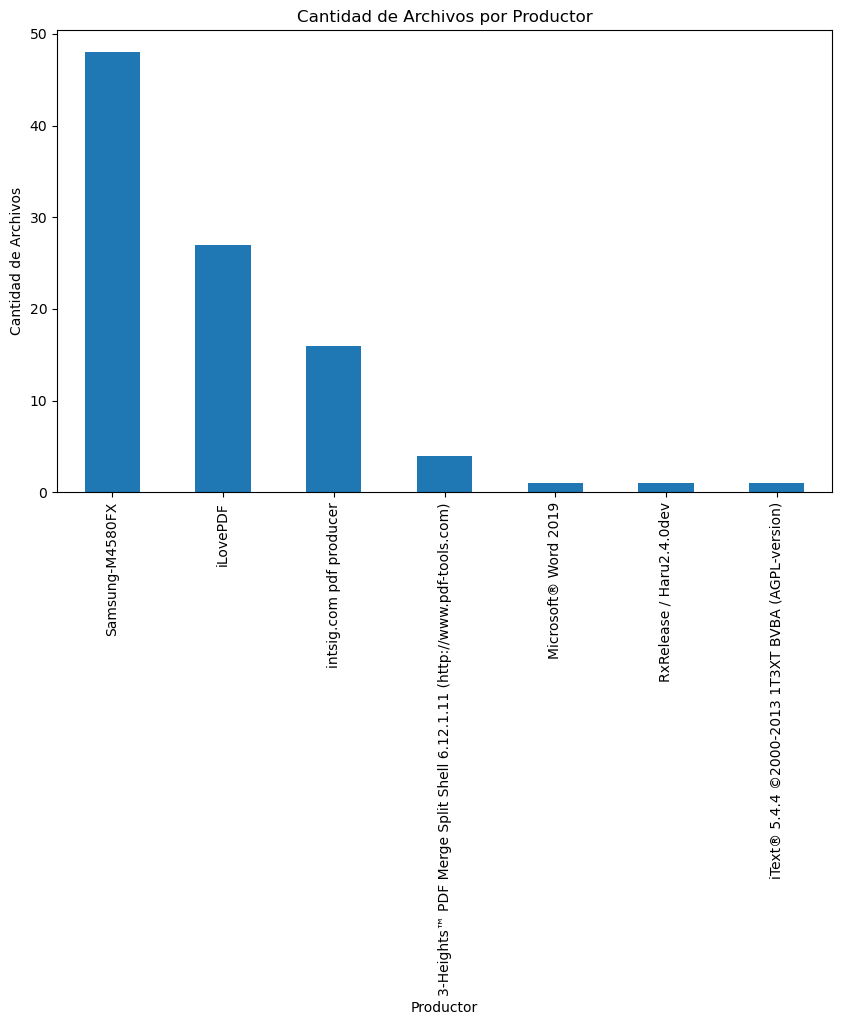

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\ETF Layer2 - Pdf_datset\metadata_2.0.csv')

# Contamos la cantidad de archivos por productor
conteo_producers = df['Producer'].value_counts()

# Mostramos el resultado
print(conteo_producers)

# Visualizamos el resultado en un gráfico de barras
conteo_producers.plot(kind='bar', figsize=(10,6))
plt.title('Cantidad de Archivos por Productor')
plt.xlabel('Productor')
plt.ylabel('Cantidad de Archivos')
plt.show()


## FileSize:

- La mayoría de los PDFs tienen 2-3 páginas. Sin embargo, hay algunos con más páginas, llegando hasta 11 páginas en un caso.

2     37
3     30
4     11
5      6
7      4
6      4
8      2
10     1
9      1
11     1
1      1
Name: TotalPages, dtype: int64


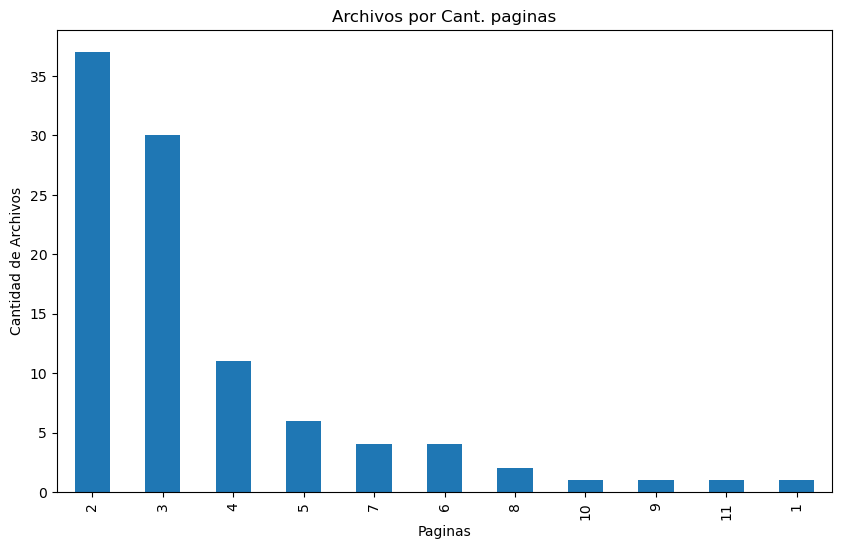

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\ETF Layer2 - Pdf_datset\metadata_2.0.csv')

# Contamos la cantidad de archivos por productor
conteo_producers = df['TotalPages'].value_counts()

# Mostramos el resultado
print(conteo_producers)

# Visualizamos el resultado en un gráfico de barras
conteo_producers.plot(kind='bar', figsize=(10,6))
plt.title('Archivos por Cant. paginas')
plt.xlabel('Paginas')
plt.ylabel('Cantidad de Archivos')
plt.show()

## TotalPages:

- Los tamaños de archivo varían ampliamente, desde poco más de 100KB hasta más de 13MB, lo que indica una diversidad en el contenido de estos documentos (por ejemplo, texto plano vs imágenes de alta resolución).

count    98.000000
mean      1.431865
std       1.473430
min       0.167760
25%       0.728625
50%       1.119777
75%       1.595646
max      13.052280
Name: FileSize, dtype: float64


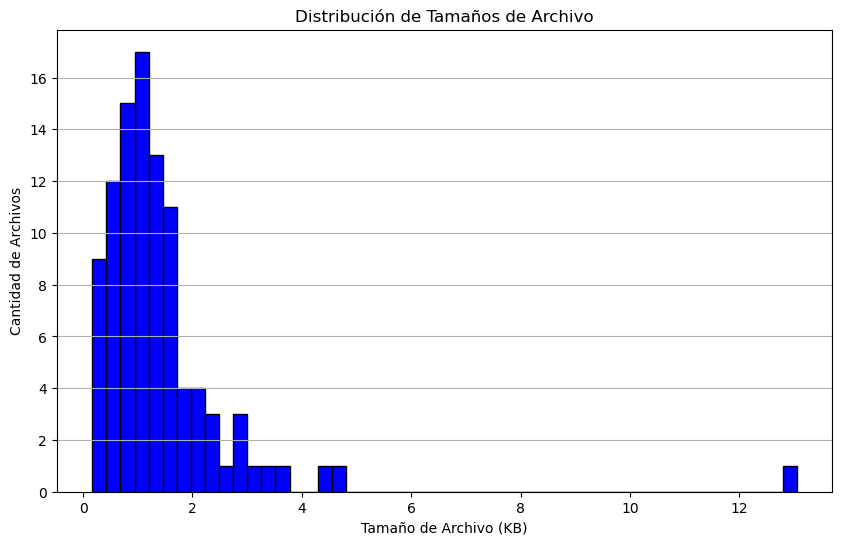

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Carga del dataset
df = pd.read_csv(r'C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\ETF Layer2 - Pdf_datset\metadata_2.0.csv') 
# Convertir tamaños de B a MB
df['FileSize'] = df['FileSize'] / 1024 / 1024

# Podemos obtener algunas estadísticas básicas
stadistics_size = df['FileSize'].describe()
print(stadistics_size)

# Histograma para visualizar la distribución de los tamaños de archivo
plt.figure(figsize=(10,6))
plt.hist(df['FileSize'], bins=50, color='blue', edgecolor='black')
plt.title('Distribución de Tamaños de Archivo')
plt.xlabel('Tamaño de Archivo (KB)')
plt.ylabel('Cantidad de Archivos')
plt.grid(axis='y')
plt.show()


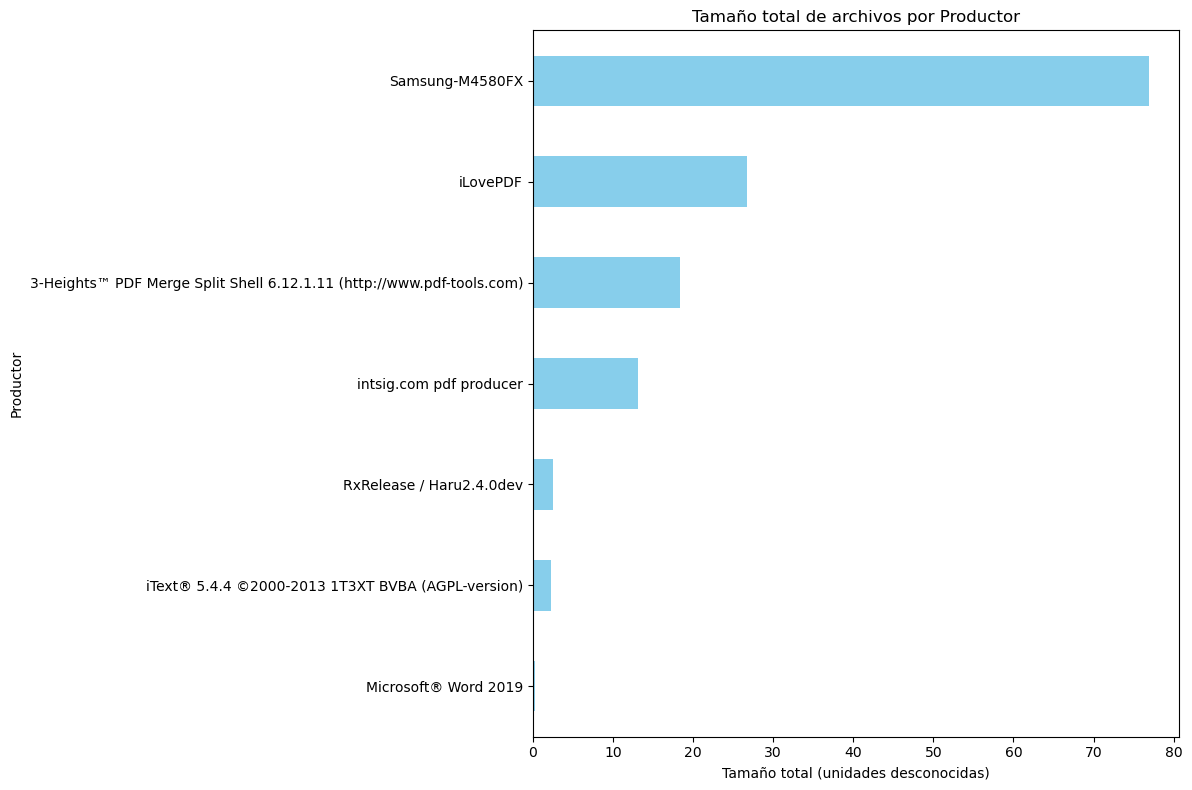

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo CSV
data = route

# Convertir tamaños de B a MB
data['FileSize'] = data['FileSize'] / 1024 / 1024

# Agrupar por 'Producer' y calcular la suma total de 'FileSize' para cada 'Producer'
grouped_data = data.groupby('Producer')['FileSize'].sum().sort_values(ascending=False)

# Visualizar los resultados
plt.figure(figsize=(12, 8))
grouped_data.plot(kind='barh', color='skyblue')
plt.title('Tamaño total de archivos por Productor')
plt.xlabel('Tamaño total (unidades desconocidas)')
plt.ylabel('Productor')
plt.gca().invert_yaxis()  # Esto es para tener el productor con el mayor tamaño en la parte superior
plt.tight_layout()
plt.show()


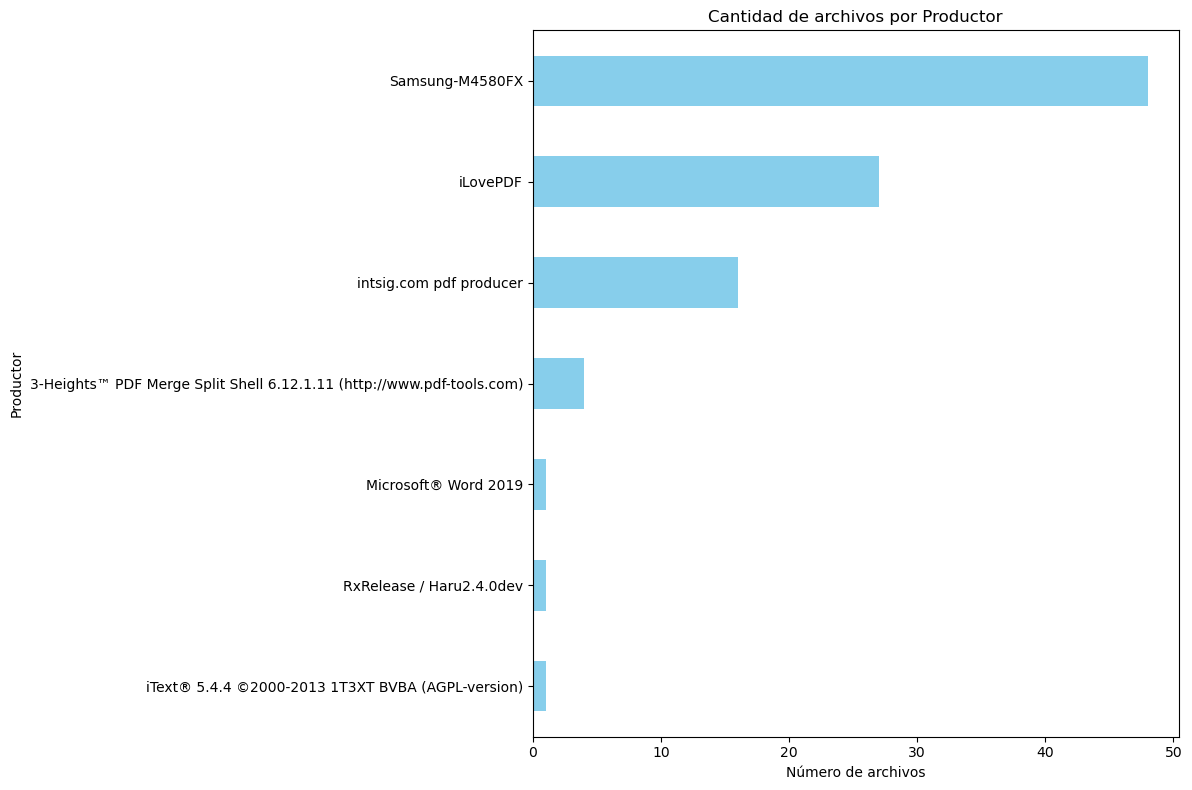

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo CSV
data = route

# Agrupar por 'Producer' y calcular la cantidad de archivos para cada 'Producer'
grouped_data = data.groupby('Producer')['FileSize'].count().sort_values(ascending=False)

# Visualizar los resultados
plt.figure(figsize=(12, 8))
grouped_data.plot(kind='barh', color='skyblue')
plt.title('Cantidad de archivos por Productor')
plt.xlabel('Número de archivos')
plt.ylabel('Productor')
plt.gca().invert_yaxis()  # Esto es para tener el productor con la mayor cantidad en la parte superior
plt.tight_layout()
plt.show()


In [60]:
import pandas as pd

# Ruta al archivo CSV
route = r'C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\ETF Layer2 - Pdf_datset\metadata_2.0.csv'

# Leer el archivo CSV y cargarlo en un DataFrame
data = pd.read_csv(route)

# Crear un diccionario que asigne un código único a cada productor
producer_codes = {producer: code for code, producer in enumerate(data['Producer'].unique(), start=1)}

# Mapear el diccionario al DataFrame para crear la nueva columna
data['producer_cod'] = data['Producer'].map(producer_codes)

# Crear un DataFrame de referencia para los códigos de productores
producer_reference = pd.DataFrame(list(producer_codes.items()), columns=['Producer', 'producer_cod'])

# Guardar el DataFrame de referencia en otro CSV
reference_route = r'C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\ETF Layer2 - Pdf_datset\producer_reference.csv'
producer_reference.to_csv(reference_route, index=False)

# Guardar el DataFrame modificado de regreso al CSV original
data.to_csv(route, index=False)


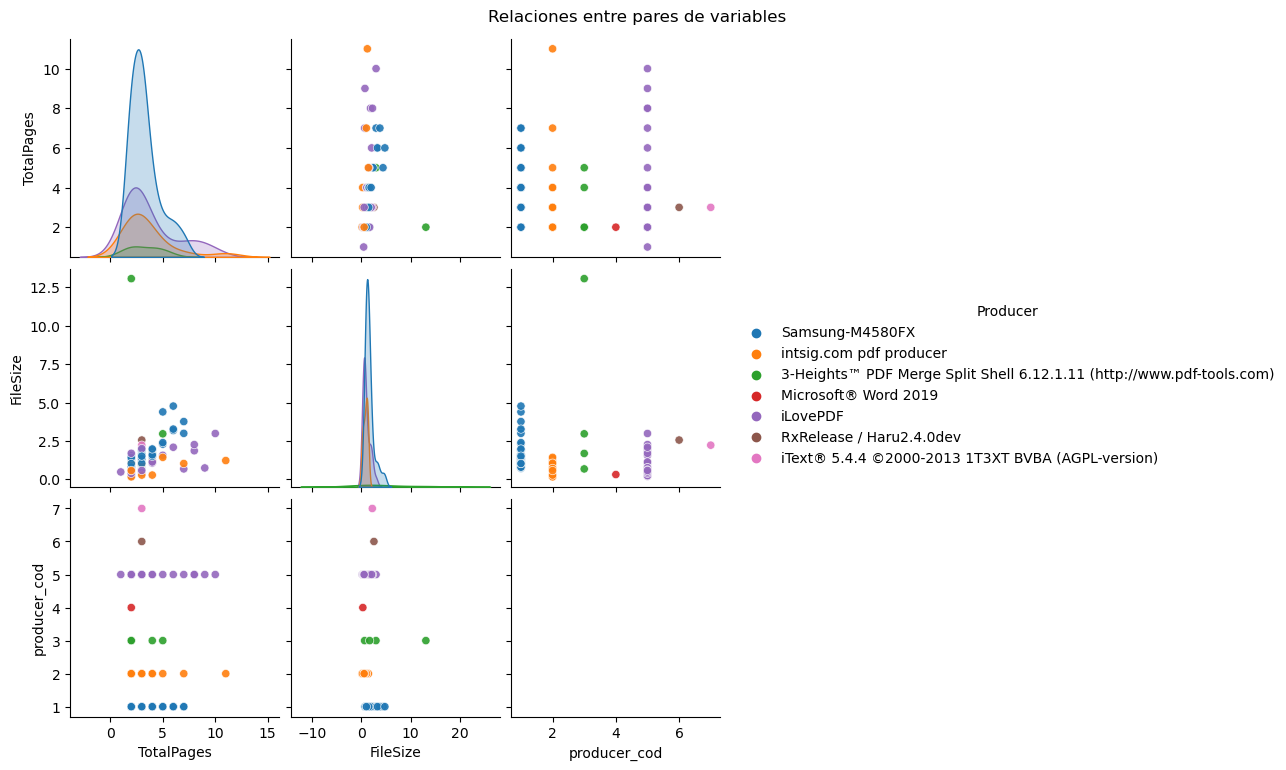

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ruta al archivo CSV
route = r'C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\ETF Layer2 - Pdf_datset\metadata_2.0.csv'

# Leer el archivo CSV y cargarlo en un DataFrame
data = pd.read_csv(route)

# Convertir FileSize de Bytes a Megabytes (MB)
data['FileSize'] = data['FileSize'] / (1024 * 1024)

# Visualizar todas las relaciones entre pares de variables
# Usar el argumento 'hue' para colorar los puntos según el 'Producer'
sns.pairplot(data, hue='Producer', diag_kind="kde", markers='o', plot_kws={'alpha': 0.9}, height=2.5)
plt.suptitle('Relaciones entre pares de variables', y=1.02)
plt.show()


## Title & Author:

- En varios casos, los campos de título y autor parecen contener nombres, lo que sugiere que estos documentos están relacionados con personas individuales. Algunos títulos como "Captura de pantalla 08-01-2022 13.59" indican que podrían haber sido tomados como capturas o escaneos de otro contenido.

## CreationDate & ModDate:

- Los documentos abarcan una variedad de fechas de creación y modificación, siendo los más recientes de enero de 2023 y los más antiguos de febrero de 2022.

## Subject:

- Algunos documentos tienen asuntos específicos mencionados, pero no poseen informacion relevante.

## Null data:

- No todos los campos están llenos para cada entrada, pero no es un aspecto a tener en cuenta en este caso.


# 3 -Comparacion de archivos de baja calidad

Hemos identificado un conjunto específico de archivos que presentan características distintas al resto de nuestro dataset. Estos archivos, listados a continuación, son imágenes que han sido convertidas a PDFs.

## Motivación

Dichos archivos muestran una calidad intrínsecamente inferior al resto debido a su origen como imágenes. Esto podría afectar la precisión y el rendimiento de los modelos de Machine Learning si se mezclan con otros archivos de mayor calidad. 

Por ende, nuestro objetivo es establecer un procedimiento que nos permita segmentar estos archivos de manera efectiva, con el fin de considerar la posibilidad de entrenar dos modelos distintos: uno para archivos convertidos de imágenes y otro para el resto.

## Lista de Archivos Convertidos de Imágenes a PDFs

- **Form1965  ENF**
- **Form1973  ENF**
- **Form16  MED**
- **Form19  CUI**
- **Form26  MED**
- **Form31  CUI**
- **Form100  CUI**
- **Form101  ENF**
- **Form103  ENF**
- **Form251  MED**
- **Form261  CUI**
- **Form487  ENF**
- **Form1302  ENF**

## Siguientes Pasos

1. Segmentar estos archivos del conjunto de datos principal.
2. Analizar las características y la calidad de estos archivos.
3. Decidir sobre la metodología de entrenamiento y las estrategias de modelado para estos datos.

**Nota**: Es esencial que adoptemos un enfoque sistemático y basado en datos para este proceso, garantizando que cualquier decisión tomada sea en beneficio de la calidad y precisión del modelo.


In [64]:
import pandas as pd
import os
import shutil
import re

def clean_directory_name(name):
    # Sustituir caracteres no permitidos
    name = re.sub(r'[<>:"/\\|?*]', '_', name)
    # Eliminar cualquier punto
    name = name.rstrip('.')
    return name

# Ruta al archivo CSV
csv_route = r'C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\ETF Layer2 - Pdf_datset\metadata_2.0.csv'

# Ruta de la carpeta que contiene todos los archivos
source_folder = r'C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\ETF Layer2 - Pdf_datset\Training Dataset\metadata_sample' 

# Leer el archivo CSV y cargarlo en un DataFrame
data = pd.read_csv(csv_route)

# Iterar sobre cada fila para obtener el productor y el nombre del archivo
for index, row in data.iterrows():
    producer = clean_directory_name(row['Producer'])
    file_name = row['Name']  

    # Crear una carpeta para el productor si aún no existe
    producer_folder = os.path.join(source_folder, producer)
    if not os.path.exists(producer_folder):
        os.makedirs(producer_folder)

    # Mover el archivo a la carpeta del productor
    source_file_path = os.path.join(source_folder, file_name)
    destination_file_path = os.path.join(producer_folder, file_name)

    # Comprobar si el archivo existe y luego moverlo
    if os.path.exists(source_file_path):
        shutil.move(source_file_path, destination_file_path)
    else:
        print(f"El archivo {file_name} no se encontró en {source_folder}")

print("Archivos organizados según productores.")


El archivo Form1- KINE.pdf no se encontró en C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\ETF Layer2 - Pdf_datset\Training Dataset\metadata_sample
El archivo Form100- CUI.pdf no se encontró en C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\ETF Layer2 - Pdf_datset\Training Dataset\metadata_sample


Archivos organizados según productores.


Se localizan los archivos de baja calidad para determinar un posible proceso de segmentacion de los mismos y se elabora un informe con los resultados.

In [22]:
import os

# Lista de archivos a buscar
files_to_search = [
    "Form1965- ENF.pdf",
    "Form1973- ENF.pdf",
    "Form16- MED.pdf",
    "Form19- CUI.pdf",
    "Form26- MED.pdf",
    "Form31- CUI.pdf",
    "Form100- CUI.pdf",
    "Form101- ENF.pdf",
    "Form103- ENF.pdf",
    "Form251- MED.pdf",
    "Form261- CUI.pdf",
    "Form487- ENF.pdf",
    "Form1302- ENF.pdf"
]

# Directorio raíz donde buscar los archivos
route = r'C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\Layer2 - Pdf_dataset'
root_folder = route + '\metadata_sample'

# Archivo de informe
report_file_path = r'C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\Layer2 - Pdf_dataset\metadata_report.txt'

# Abre el archivo de informe en modo de escritura
with open(report_file_path, 'w') as report_file:
    # Recorre las carpetas y subcarpetas dentro del directorio raíz
    for folder_name, subfolders, filenames in os.walk(root_folder):
        for file_name in filenames:
            # Si el nombre del archivo está en la lista de archivos a buscar
            if file_name in files_to_search:
                report_file.write(f"El archivo {file_name} se encuentra en: {folder_name}\n")

print(f"Informe guardado en {report_file_path}")




Informe guardado en C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\Layer2 - Pdf_dataset\metadata_report.txt


Conclusion: Se decide utilizar un modelo de segmentacion de archivos basado en la fuente de creacion de los datos. Ya que los archivos de alta calidad son generados por la misma fuente. Samsung-M4580FX.

---

# Interpretaciones y Consideraciones

1. La marca **Samsung-M4580FX** parece ser el productor dominante y también está vinculada con el creador principal. Esto podría es importante en análisis futuros, especialmente si se considera la calidad o características específicas de los archivos de esta fuente.

2. La falta de datos en la columna 'Creator' no es motivo de preocupación ya que por una investigación se determino que el creador es la maquina Samsung-M4580FX.

3. Se continua con el proceso de separación de datos el propósito de este proceso es separar los archivos a formatos de alta y baja calidad para entrenar el modelo.

- **High Quality Data:** Archivos generados por `Samsung-M4580FX`
- **Low Quality Data:** Archivos generados por otras máquinas

---

# 4 -Análisis de Area en Pixeles  

A partir de los requerimientos de Azure Form Recognizer, se determina que los archivos PDFs deben tener un tamaño menor a 10000 x 10000 pixeles, con una resolución de 150 dpi.

## Motivación

- Se analiza el tamaño de las hojas y determinar si cumplen con los requerimientos de Azure.

In [28]:
# analizar 1 pdf para ver si mide menos de 10000x10000 pixeles cada pagina
import PyPDF2
from pdf2image import convert_from_path

def analyze_pdf(file_path):
    # Abrir el archivo PDF
    with open(file_path, 'rb') as file:
        # Usar PyPDF2 para determinar el número de páginas
        pdf = PyPDF2.PdfReader(file)
        num_pages = len(pdf.pages)
        
        # Convertir las páginas del PDF en imágenes
        images = convert_from_path(file_path)

        # Almacenar la cantidad de píxeles de cada página
        pixels_per_page = []
        
        for image in images:
            width, height = image.size
            pixels_per_page.append(width * height)
        
        return pixels_per_page

file_path = r'C:\Users\HP\My Drive\Inteligencia Artificial\PROJECTS\ML Ops - House24 - Form Recognizer\Layer2 - Pdf_dataset\metadata_sample\Samsung-M4580FX\Form256- FONO.pdf'  # Reemplaza esto con la ruta de tu archivo
pixels_per_page = analyze_pdf(file_path)

for i, pixels in enumerate(pixels_per_page, 1):
    print(f"Página {i}: {pixels} píxeles")




Página 1: 3892014 píxeles
Página 2: 3892014 píxeles


# Conclusion: 

- Se determina que los archivos cumplen con los requerimientos de Azure Form Recognizer, ya que poseen un tamaño menor a 10000 x 10000 pixeles, con una resolución de 150 dpi.